# FPH annual report probability visualisation
This notebook loads Fisher & Paykel Healthcare (FPH) annual report BERT outputs (finance, social, env, maori probabilities), combines them with a year column, and plots trends of how often each label is predicted strongly at three thresholds: >0.5, >0.75, >0.95.


In [1]:
# One-time install of plotting libraries (uncomment if needed)
%pip install -q matplotlib seaborn



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_colwidth", 120)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 10)

data_dir = Path("data")
csv_paths = sorted(data_dir.glob("preds-BGP*.csv"))

csv_paths


[PosixPath('data/preds-BGP2018.csv'),
 PosixPath('data/preds-BGP2019.csv'),
 PosixPath('data/preds-BGP2020.csv'),
 PosixPath('data/preds-BGP2021.csv'),
 PosixPath('data/preds-BGP2022.csv'),
 PosixPath('data/preds-BGP2023.csv'),
 PosixPath('data/preds-BGP2024.csv'),
 PosixPath('data/preds-BGP2025.csv')]

In [3]:
# Load all yearly CSVs and attach a year column from the filename
def load_yearly(paths):
    frames = []
    for path in paths:
        year = int(path.stem.replace("preds-BGP", ""))
        df = pd.read_csv(path)
        df["year"] = year
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

df = load_yearly(csv_paths)
df.head()


,sentence,source_page,source_pdf,prob_fin_label,prob_soc_label,prob_env_label,prob_maori_label,year
0,ANNUAL REPORT for the period ended 28 January 2018,1,BGP2018,0.008978,0.866229,0.064396,0.000132,2018
1,Earning before interest and tax (EBIT) is a non-GAAP measure.,5,BGP2018,0.069403,0.002300,0.984767,0.000784,2018
2,Refer to the Consolidated Income Statement on Page 15.,5,BGP2018,0.110371,0.990810,0.000789,0.000539,2018
3,"Overview The pace of change in technology and in society more broadly requires retailers to be prepared to adapt, an...",6,BGP2018,0.466351,0.961394,0.002607,0.000160,2018
4,"However, as important as it is to stay abreast of new tools, new techniques and new opportunities, it is in large pa...",6,BGP2018,0.999471,0.011178,0.002361,0.002258,2018


In [4]:
# Quick data health check
prob_cols = ["prob_fin_label", "prob_soc_label", "prob_env_label", "prob_maori_label"]
display(df[["year"] + prob_cols].describe(include="all"))


,year,prob_fin_label,prob_soc_label,prob_env_label,prob_maori_label
count,7489.000000,7489.000000,7489.000000,7489.000000,7489.000000
mean,2021.893978,0.402951,0.392654,0.247083,0.003544
std,2.325014,0.447639,0.464909,0.383565,0.032208
min,2018.000000,0.000155,0.000176,0.000212,0.000041
25%,2020.000000,0.005466,0.002038,0.002060,0.000782
50%,2022.000000,0.071695,0.017527,0.007070,0.001376
75%,2024.000000,0.978512,0.995351,0.422375,0.002298
max,2025.000000,0.999628,0.999309,0.999496,0.999128


In [5]:
# Reshape to long format for easier analysis across labels
long_df = df.melt(id_vars=["year"], value_vars=prob_cols, var_name="label", value_name="probability")
long_df["label"] = long_df["label"].str.replace("prob_", "").str.replace("_label", "").str.upper()
long_df.head()


,year,label,probability
0,2018,FIN,0.008978
1,2018,FIN,0.069403
2,2018,FIN,0.110371
3,2018,FIN,0.466351
4,2018,FIN,0.999471


In [6]:
# Helpers to summarize and plot strong predictions at arbitrary thresholds
def summarize_over_threshold(df_long, threshold):
    agg = (
        df_long.assign(over=df_long["probability"] > threshold)
        .groupby(["year", "label"])
        .agg(
            total_sentences=("probability", "size"),
            over_count=("over", "sum"),
            over_share=("over", "mean"),  # same as count/total
            mean_prob_over=("probability", lambda s: s[s > threshold].mean()),
        )
        .reset_index()
    )
    # agg["mean_prob_over"] = agg["mean_prob_over"].fillna(0)
    agg["threshold"] = threshold
    return agg


thresholds = [0.5, 0.75, 0.95]
summaries = {thr: summarize_over_threshold(long_df, thr) for thr in thresholds}

# Quick peek at the 0.5 summary
summaries[0.5].head()


,year,label,total_sentences,over_count,over_share,mean_prob_over,threshold
0,2018,ENV,716,126,0.175978,0.890912,0.5
1,2018,FIN,716,316,0.441341,0.940883,0.5
2,2018,MAORI,716,0,0.000000,NaN,0.5
3,2018,SOC,716,285,0.398045,0.959603,0.5
4,2019,ENV,821,145,0.176614,0.884876,0.5


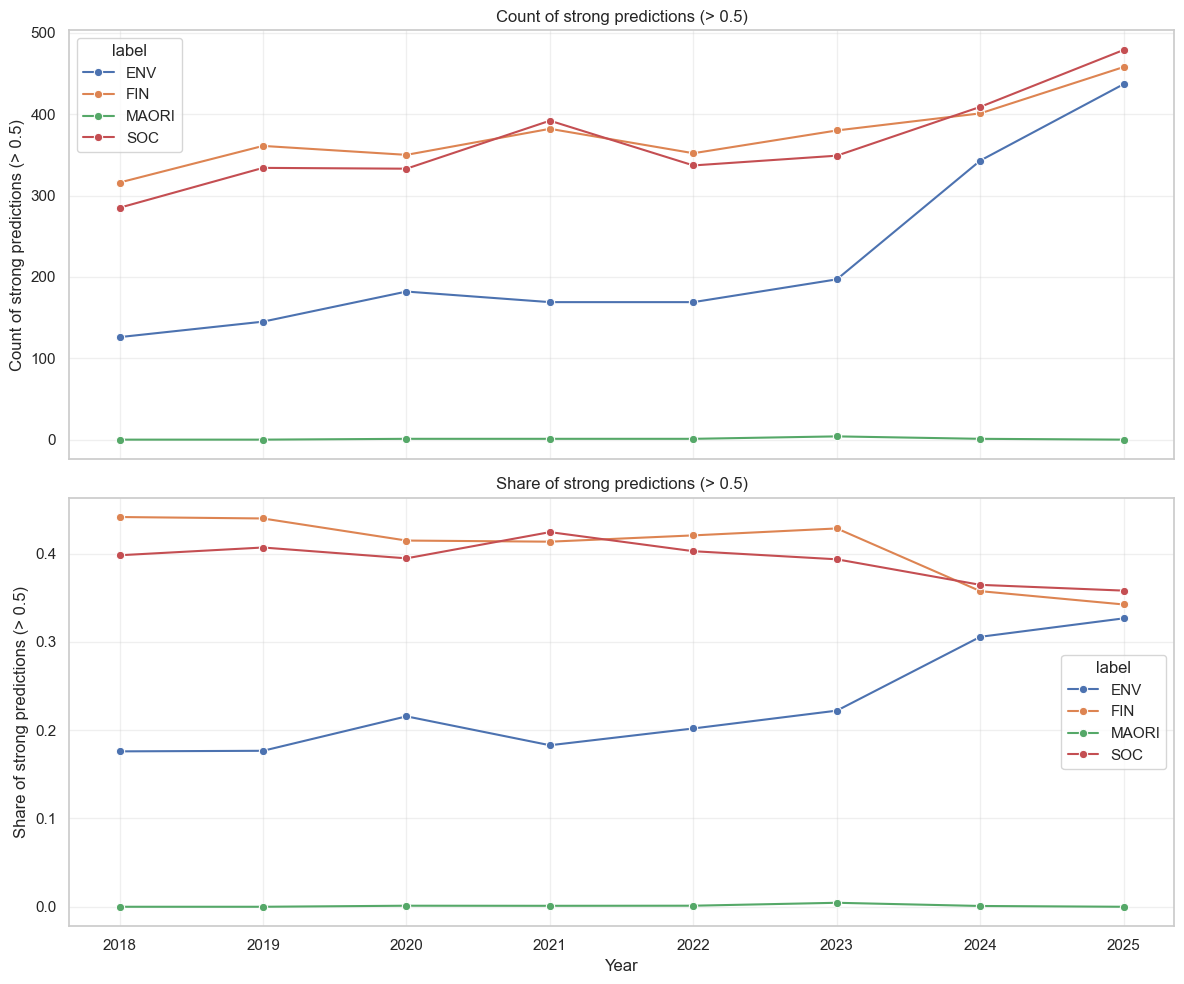

In [7]:
# Combined view for threshold > 0.5 (counts, shares)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plot_map = [
    ("over_count", "Count of strong predictions (> 0.5)"),
    ("over_share", "Share of strong predictions (> 0.5)")
]
summary = summaries[0.5]
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.grid(True, alpha=0.3)
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


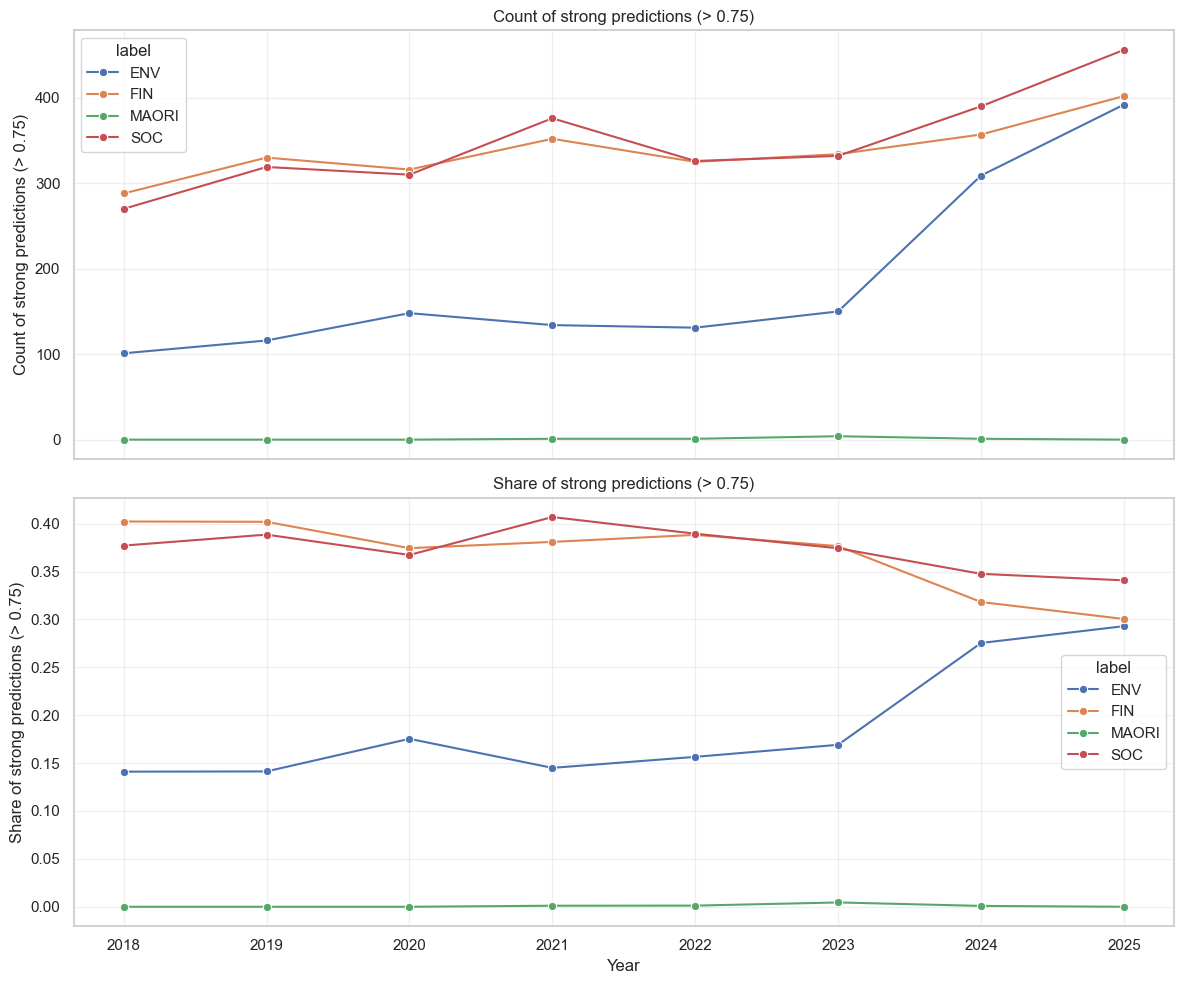

In [8]:
# Combined view for threshold > 0.75 
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plot_map = [
    ("over_count", "Count of strong predictions (> 0.75)"),
    ("over_share", "Share of strong predictions (> 0.75)")
]
summary = summaries[0.75]
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.grid(True, alpha=0.3)
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


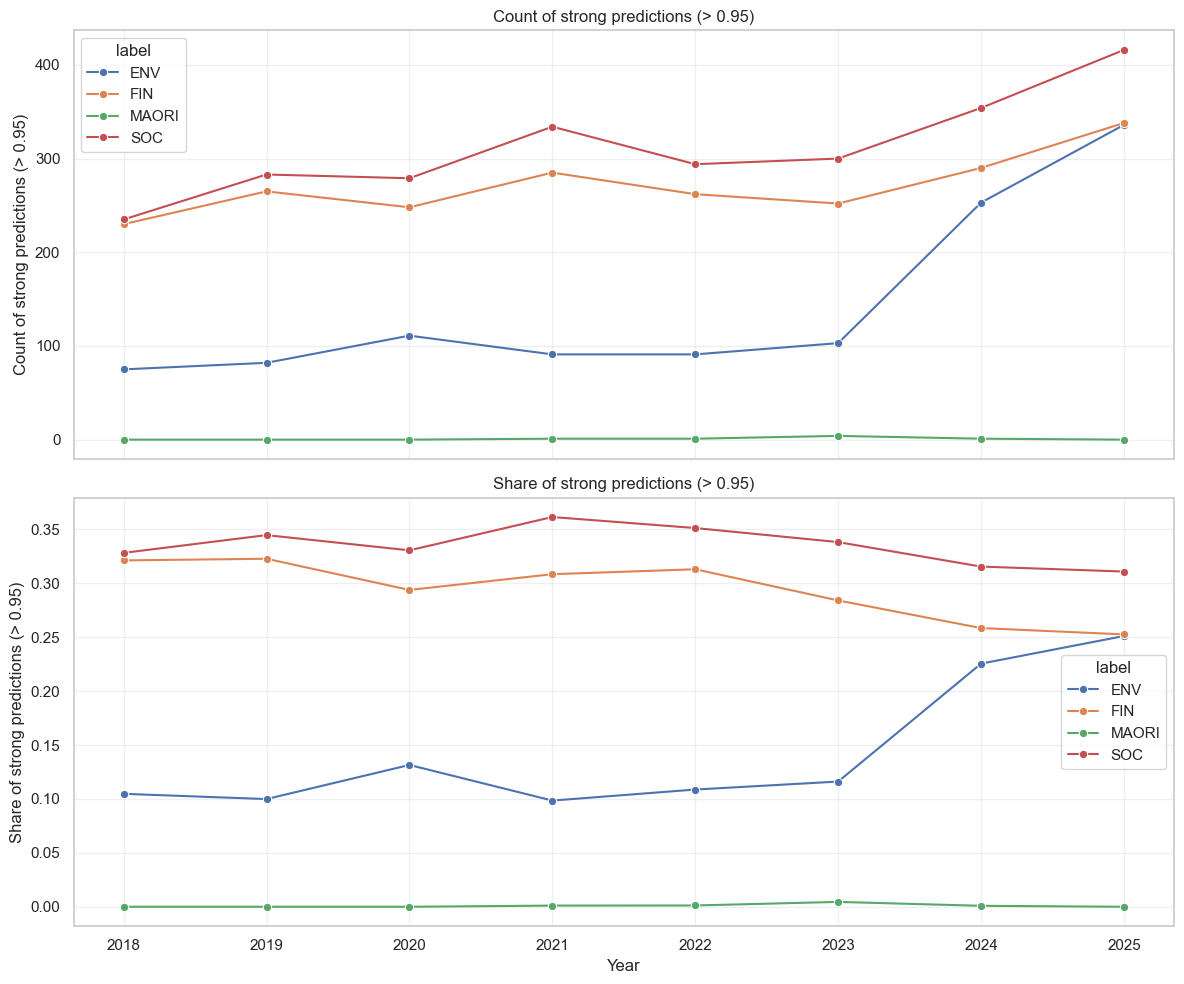

In [9]:
# Combined view for threshold > 0.95 
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plot_map = [
    ("over_count", "Count of strong predictions (> 0.95)"),
    ("over_share", "Share of strong predictions (> 0.95)")
]
summary = summaries[0.95]
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.grid(True, alpha=0.3)
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


Notes
- over_count: how many sentences per label per year with predicted probability above the chosen threshold.
- over_share: same as over_count / total sentences for that year+label (proportion of strong predictions).
- mean_prob_over: average probability for those sentences above the threshold (0 if none above threshold).
